# 🔁 Backtesting Multi-Estrategia con Grid TP/SL/Días

Este notebook permite ejecutar un backtesting sobre señales generadas por múltiples estrategias ubicadas en:
📁 `D:/trading/my_modules/tuning_estrategias`

Cada estrategia debe tener una función `generar_senales(df)` y devolver un DataFrame con columnas:
- `fecha`, `signal`, `estrategia`

El notebook aplica reglas de salida comunes:
- ✅ Take Profit (`tp_pct`)
- ❌ Stop Loss (`sl_pct`)
- ⏳ Timeout (`dias_max`)

Y evalúa métricas clave por combinación.

In [1]:

# 📦 Imports
import os
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import timedelta
from importlib import import_module

In [2]:

# 📁 Cargar señales desde carpeta

import sys
sys.path.append("D:/trading")
carpeta_estrategias = Path("D:/trading/my_modules/tuning_estrategias")

estrategias = {}
for archivo in carpeta_estrategias.glob("*.py"):
    nombre = archivo.stem
    mod = import_module(f"my_modules.tuning_estrategias.{nombre}")
    estrategias[nombre] = mod.generar_senales

print(f"✅ Estrategias cargadas: {list(estrategias.keys())}")

✅ Estrategias cargadas: ['bollinger_breakout_v4', 'cruce_medias_v4']


In [3]:

# 📈 Cargar históricos
ruta_historicos = Path("D:/trading/data/historic")
historicos = {}
for archivo in ruta_historicos.glob("*.parquet"):
    simbolo = archivo.stem
    df = pd.read_parquet(archivo)
    if "fecha" in df.columns:
        df["fecha"] = pd.to_datetime(df["fecha"])
        historicos[simbolo] = df.sort_values("fecha").reset_index(drop=True)

print(f"✅ Históricos cargados: {len(historicos)} símbolos")

✅ Históricos cargados: 48 símbolos


In [4]:

# 🧠 Función de evaluación con TP, SL, Timeout

def evaluar_operaciones(df_signals, df_precio, tp_pct, sl_pct, dias_max):
    resultados = []

    df_signals = df_signals[df_signals["signal"] != "hold"].copy()
    df_signals["fecha"] = pd.to_datetime(df_signals["fecha"])
    df_precio["fecha"] = pd.to_datetime(df_precio["fecha"])
    df_precio = df_precio.sort_values("fecha")

    df_merged = df_precio.merge(df_signals, on="fecha")

    for _, row in df_merged.iterrows():
        fecha_entrada = row["fecha"]
        precio_entrada = row["close"]
        signal = row["signal"]
        estrategia = row.get("estrategia", "unknown")

        df_rango = df_precio[(df_precio["fecha"] > fecha_entrada) &
                              (df_precio["fecha"] <= fecha_entrada + timedelta(days=dias_max))]
        if df_rango.empty:
            continue

        tipo_salida = "TIMEOUT"
        fila_salida = df_rango.iloc[-1]

        for _, f in df_rango.iterrows():
            if signal == "buy":
                if f["high"] >= precio_entrada * (1 + tp_pct):
                    tipo_salida = "TP"; fila_salida = f; break
                if f["low"] <= precio_entrada * (1 - sl_pct):
                    tipo_salida = "SL"; fila_salida = f; break
            elif signal == "sell":
                if f["low"] <= precio_entrada * (1 - tp_pct):
                    tipo_salida = "TP"; fila_salida = f; break
                if f["high"] >= precio_entrada * (1 + sl_pct):
                    tipo_salida = "SL"; fila_salida = f; break

        precio_salida = fila_salida["close"]
        retorno = precio_salida - precio_entrada if signal == "buy" else precio_entrada - precio_salida
        ret_pct = (precio_salida / precio_entrada - 1) * (1 if signal == "buy" else -1)
        log_ret = np.log(precio_salida / precio_entrada) * (1 if signal == "buy" else -1)
        dias = (fila_salida["fecha"] - fecha_entrada).days

        resultados.append({
            "estrategia": estrategia,
            "fecha": fecha_entrada,
            "signal": signal,
            "retorno": retorno,
            "ret_pct": ret_pct,
            "log_ret": log_ret,
            "dias": dias,
            "tipo_salida": tipo_salida
        })

    return pd.DataFrame(resultados)

In [5]:
# %%
# 📘 Generar todas las combinaciones posibles de TP, SL y DÍAS

import itertools

# Definir valores individuales por parámetro
tp_values = [0.03, 0.04, 0.05]
sl_values = [0.01, 0.02]
dias_values = [5, 7]

# Crear producto cartesiano de combinaciones
param_grid = list(itertools.product(tp_values, sl_values, dias_values))

# Ver cuántas combinaciones se van a evaluar
print(f"🔄 Total combinaciones a evaluar: {len(param_grid)}")
for comb in param_grid:
    print(f"TP: {comb[0]*100:.0f}%, SL: {comb[1]*100:.0f}%, Días: {comb[2]}")

🔄 Total combinaciones a evaluar: 12
TP: 3%, SL: 1%, Días: 5
TP: 3%, SL: 1%, Días: 7
TP: 3%, SL: 2%, Días: 5
TP: 3%, SL: 2%, Días: 7
TP: 4%, SL: 1%, Días: 5
TP: 4%, SL: 1%, Días: 7
TP: 4%, SL: 2%, Días: 5
TP: 4%, SL: 2%, Días: 7
TP: 5%, SL: 1%, Días: 5
TP: 5%, SL: 1%, Días: 7
TP: 5%, SL: 2%, Días: 5
TP: 5%, SL: 2%, Días: 7


In [6]:
from joblib import Parallel, delayed
from tqdm import tqdm

def ejecutar_backtest(simbolo, df, nombre_est, funcion, tp_pct, sl_pct, dias_max):
    try:
        df_signals = funcion(df.copy())
        df_eval = evaluar_operaciones(df_signals, df.copy(), tp_pct, sl_pct, dias_max)
        if df_eval.empty:
            return None
        df_eval["simbolo"] = simbolo
        df_eval["estrategia"] = nombre_est
        df_eval["tp_pct"] = tp_pct
        df_eval["sl_pct"] = sl_pct
        df_eval["dias_max"] = dias_max
        return df_eval
    except Exception as e:
        print(f"❌ Error {nombre_est} {simbolo}: {e}")
        return None

# Armar lista de tareas
tareas = []
for tp_pct, sl_pct, dias_max in param_grid:
    for simbolo, df in historicos.items():
        for nombre_est, funcion in estrategias.items():
            tareas.append((simbolo, df, nombre_est, funcion, tp_pct, sl_pct, dias_max))

# Ejecutar en paralelo
resultados = Parallel(n_jobs=-1, backend="loky")(
    delayed(ejecutar_backtest)(*args) for args in tqdm(tareas)
)

# Consolidar resultados
df = pd.concat([r for r in resultados if r is not None], ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1152/1152 [00:30<00:00, 37.83it/s]


In [7]:
def metricas_avanzadas(df):
    positivos = df[df["retorno"] > 0]["retorno"]
    negativos = df[df["retorno"] <= 0]["retorno"]
    expectancy = positivos.mean() * (len(positivos)/len(df)) + negativos.mean() * (len(negativos)/len(df))
    pl_ratio = positivos.mean() / abs(negativos.mean()) if not negativos.empty else None
    profit_factor = positivos.sum() / abs(negativos.sum()) if not negativos.empty else None
    sharpe = df["retorno"].mean() / df["retorno"].std() if df["retorno"].std() > 0 else None
    return pd.Series({
        "expectancy": expectancy,
        "pl_ratio": pl_ratio,
        "profit_factor": profit_factor,
        "sharpe": sharpe
    })

df_advanced = df.groupby(["estrategia", "tp_pct", "sl_pct", "dias_max"]).apply(metricas_avanzadas).reset_index()

C:\Users\leant\AppData\Local\Temp\ipykernel_21328\852349600.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_advanced = df.groupby(["estrategia", "tp_pct", "sl_pct", "dias_max"]).apply(metricas_avanzadas).reset_index()


In [9]:
# Agrupación básica
df_grouped = df.groupby(
    ["estrategia", "tp_pct", "sl_pct", "dias_max"]
).agg(
    n_trades=("ret_pct", "count"),
    winrate=("retorno", lambda x: (x > 0).mean()),
    avg_profit=("retorno", "mean"),
    score=("retorno", lambda x: x.mean() * (x > 0).mean())
).reset_index()

# Función con métricas avanzadas
def metricas_avanzadas(grupo):
    positivos = grupo[grupo["retorno"] > 0]["retorno"]
    negativos = grupo[grupo["retorno"] <= 0]["retorno"]
    expectancy = (
        positivos.mean() * len(positivos) / len(grupo)
        + negativos.mean() * len(negativos) / len(grupo)
        if len(grupo) > 0 else 0
    )
    pl_ratio = positivos.mean() / abs(negativos.mean()) if not negativos.empty and negativos.mean() != 0 else None
    profit_factor = positivos.sum() / abs(negativos.sum()) if not negativos.empty and negativos.sum() != 0 else None
    sharpe = grupo["retorno"].mean() / grupo["retorno"].std() if grupo["retorno"].std() > 0 else None
    return pd.Series({
        "expectancy": expectancy,
        "pl_ratio": pl_ratio,
        "profit_factor": profit_factor,
        "sharpe": sharpe
    })

# Calcular y unir
df_metrics = df.groupby(["estrategia", "tp_pct", "sl_pct", "dias_max"]).apply(metricas_avanzadas).reset_index()
df_grouped_full = pd.merge(df_grouped, df_metrics, on=["estrategia", "tp_pct", "sl_pct", "dias_max"])


C:\Users\leant\AppData\Local\Temp\ipykernel_21328\4176025257.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_metrics = df.groupby(["estrategia", "tp_pct", "sl_pct", "dias_max"]).apply(metricas_avanzadas).reset_index()


In [10]:
# Ordenar combinaciones por profit promedio
top10_profit = df_grouped_full.sort_values("avg_profit", ascending=False).head(10)

# Seleccionar columnas clave incluyendo métricas avanzadas
columnas = [
    "estrategia", "tp_pct", "sl_pct", "dias_max", "n_trades",
    "winrate", "avg_profit", "score",
    "expectancy", "pl_ratio", "profit_factor", "sharpe"
]

# Mostrar la tabla
display(top10_profit[columnas])


,estrategia,tp_pct,sl_pct,dias_max,n_trades,winrate,avg_profit,score,expectancy,pl_ratio,profit_factor,sharpe
19,cruce_medias_v4,0.04,0.02,7,3026,0.486781,0.239647,0.116655,0.239647,1.452511,1.377688,0.076075
20,cruce_medias_v4,0.05,0.01,5,3026,0.469597,0.229584,0.107812,0.229584,1.716546,1.519758,0.087536
21,cruce_medias_v4,0.05,0.01,7,3026,0.431593,0.228422,0.098585,0.228422,1.919372,1.457384,0.078856
23,cruce_medias_v4,0.05,0.02,7,3026,0.476867,0.217836,0.103879,0.217836,1.453738,1.325170,0.062430
16,cruce_medias_v4,0.04,0.01,5,3026,0.474223,0.216393,0.102619,0.216393,1.653205,1.491106,0.086892
15,cruce_medias_v4,0.03,0.02,7,3026,0.503635,0.213670,0.107612,0.213670,1.334382,1.353926,0.075274
17,cruce_medias_v4,0.04,0.01,7,3026,0.438863,0.213289,0.093605,0.213289,1.827895,1.429590,0.078018
22,cruce_medias_v4,0.05,0.02,5,3026,0.502313,0.207860,0.104411,0.207860,1.364332,1.377015,0.071625
12,cruce_medias_v4,0.03,0.01,5,3026,0.482155,0.205966,0.099307,0.205966,1.582398,1.473336,0.086160
18,cruce_medias_v4,0.04,0.02,5,3026,0.509253,0.204133,0.103955,0.204133,1.326752,1.376785,0.073890


C:\Users\leant\AppData\Local\Temp\ipykernel_21328\487631971.py:10: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\trading_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


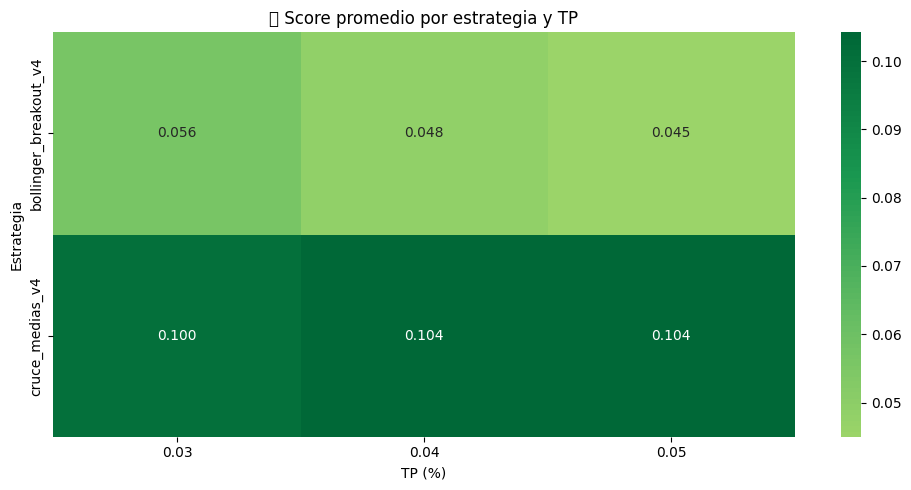

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
pivot_score = df_grouped_full.pivot_table(index="estrategia", columns="tp_pct", values="score", aggfunc="mean")
sns.heatmap(pivot_score, annot=True, fmt=".3f", cmap="RdYlGn", center=0)
plt.title("📊 Score promedio por estrategia y TP")
plt.xlabel("TP (%)")
plt.ylabel("Estrategia")
plt.tight_layout()
plt.show()

C:\Users\leant\AppData\Local\Temp\ipykernel_21328\316511543.py:19: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\trading_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


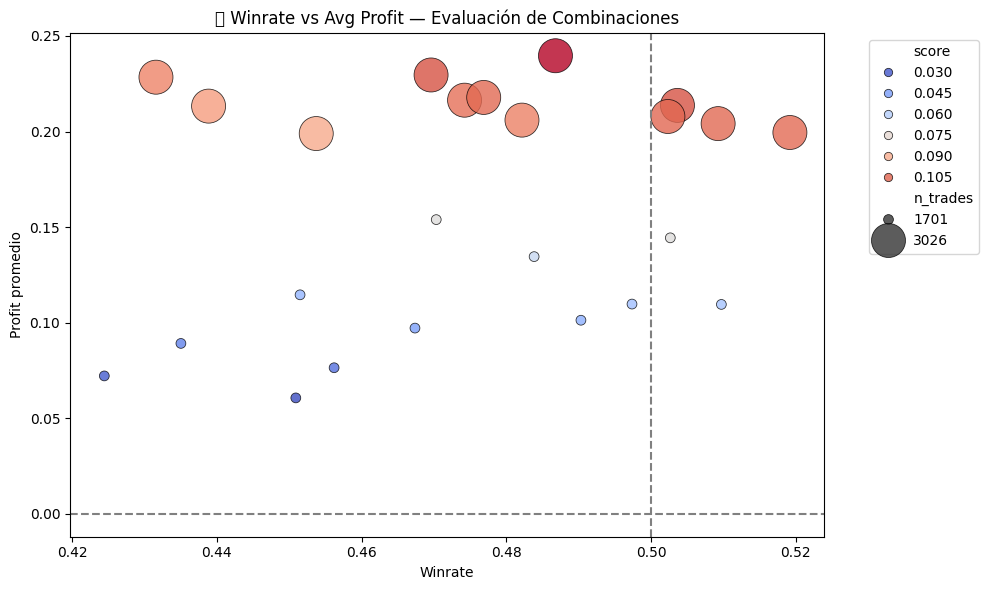

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_grouped_full,
    x="winrate",
    y="avg_profit",
    size="n_trades",
    hue="score",
    palette="coolwarm",
    sizes=(50, 600),
    alpha=0.8,
    edgecolor="black"
)
plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0.5, linestyle="--", color="gray")
plt.title("🎯 Winrate vs Avg Profit — Evaluación de Combinaciones")
plt.xlabel("Winrate")
plt.ylabel("Profit promedio")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


C:\Users\leant\AppData\Local\Temp\ipykernel_21328\3111062109.py:19: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\trading_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


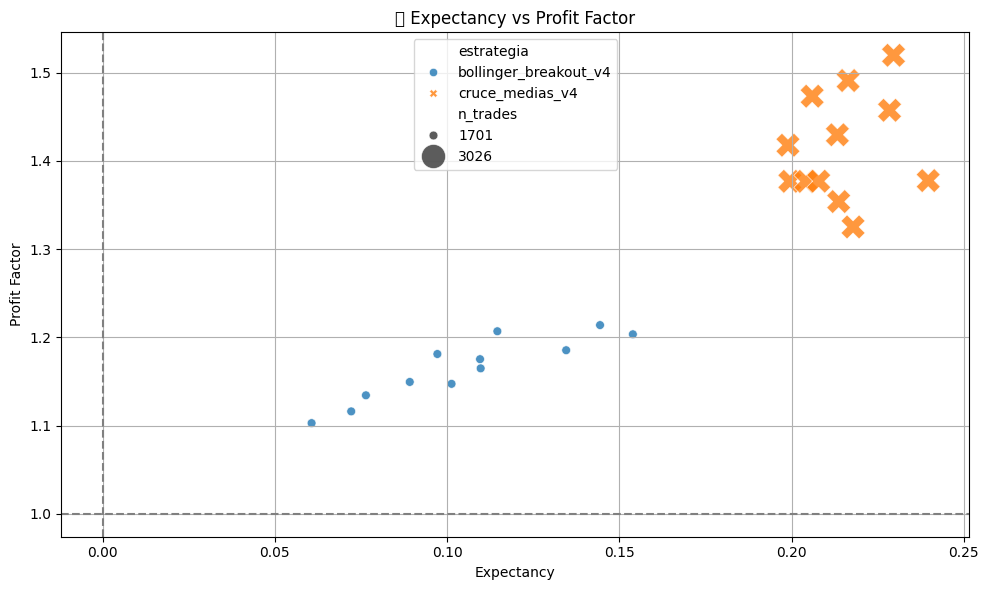

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_grouped_full,
    x="expectancy",
    y="profit_factor",
    hue="estrategia",
    style="estrategia",
    size="n_trades",
    palette="tab10",
    sizes=(40, 300),
    alpha=0.8
)
plt.axvline(0, linestyle="--", color="gray")
plt.axhline(1, linestyle="--", color="gray")
plt.title("💡 Expectancy vs Profit Factor")
plt.xlabel("Expectancy")
plt.ylabel("Profit Factor")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\leant\AppData\Local\Temp\ipykernel_21328\2194342735.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_grouped_full, x="sl_pct", y="score", palette="Set2")
C:\Users\leant\AppData\Local\Temp\ipykernel_21328\2194342735.py:6: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\trading_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


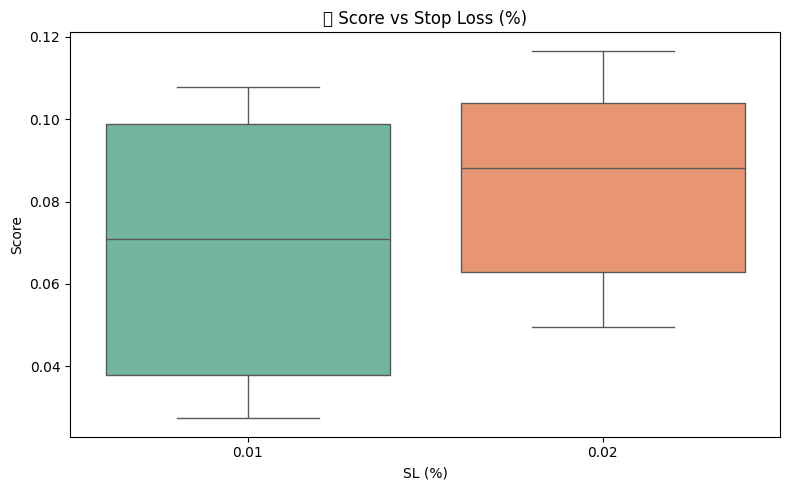

In [17]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_grouped_full, x="sl_pct", y="score", palette="Set2")
plt.title("📦 Score vs Stop Loss (%)")
plt.xlabel("SL (%)")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


In [18]:
top_sharpe = df_grouped_full.sort_values("sharpe", ascending=False).head(10)
display(top_sharpe[[
    "estrategia", "tp_pct", "sl_pct", "dias_max", "n_trades",
    "winrate", "avg_profit", "score", "expectancy", "pl_ratio", "profit_factor", "sharpe"
]])


,estrategia,tp_pct,sl_pct,dias_max,n_trades,winrate,avg_profit,score,expectancy,pl_ratio,profit_factor,sharpe
20,cruce_medias_v4,0.05,0.01,5,3026,0.469597,0.229584,0.107812,0.229584,1.716546,1.519758,0.087536
16,cruce_medias_v4,0.04,0.01,5,3026,0.474223,0.216393,0.102619,0.216393,1.653205,1.491106,0.086892
12,cruce_medias_v4,0.03,0.01,5,3026,0.482155,0.205966,0.099307,0.205966,1.582398,1.473336,0.086160
13,cruce_medias_v4,0.03,0.01,7,3026,0.453734,0.198937,0.090265,0.198937,1.706870,1.417745,0.079568
21,cruce_medias_v4,0.05,0.01,7,3026,0.431593,0.228422,0.098585,0.228422,1.919372,1.457384,0.078856
17,cruce_medias_v4,0.04,0.01,7,3026,0.438863,0.213289,0.093605,0.213289,1.827895,1.429590,0.078018
19,cruce_medias_v4,0.04,0.02,7,3026,0.486781,0.239647,0.116655,0.239647,1.452511,1.377688,0.076075
15,cruce_medias_v4,0.03,0.02,7,3026,0.503635,0.213670,0.107612,0.213670,1.334382,1.353926,0.075274
14,cruce_medias_v4,0.03,0.02,5,3026,0.519167,0.199486,0.103567,0.199486,1.275170,1.376833,0.075002
18,cruce_medias_v4,0.04,0.02,5,3026,0.509253,0.204133,0.103955,0.204133,1.326752,1.376785,0.073890


In [19]:
df_grouped_full.to_csv("resultados_backtest_quant.csv", index=False)
print("✅ Resultados exportados a 'resultados_backtest_quant.csv'")


✅ Resultados exportados a 'resultados_backtest_quant.csv'
